In [1]:
import os
import numpy as np
import scipy.io
from scipy.optimize import nnls
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

(84, 76, 500)


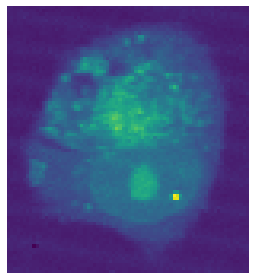

In [2]:
path = r'C:\Users\pilhardt\Downloads\raman_project\data\hyperspectal_super_resolution_data'

def load_image(base_path, id_name):
    input_path = os.path.join(base_path, id_name + ".mat")
    output_data = scipy.io.loadmat(input_path)
    output_values = list(output_data.values())
    output_image = output_values[3]
    return output_image

def plot_image(img, cmap = 'viridis'):
    if img.ndim == 3:
        img = img.mean(axis = 2)
    fig, ax = plt.subplots(1, 1, figsize = (5,4))
    ax.imshow(img, cmap = cmap, interpolation = 'nearest')
    ax.axis('off')
    fig.tight_layout()
    plt.show()

img = load_image(path, 'Cell-HR_Norm_500-03-079-136')
print(img.shape)
plot_image(img)

In [3]:
# for file in os.listdir(path):
#     im = load_image(path, file[:-4])
#     print(file[:-4])
#     plot_image(im)

In [4]:
# adapted from: Adrien Lagrange (https://github.com/Laadr/VCA)

def estimate_snr(Y, r_m, x):
    L, N = Y.shape   # (num_channels, num_pixels)
    p, _ = x.shape   # p number of endmembers

    P_y = np.sum(Y**2) / float(N)
    P_x = np.sum(x**2) / float(N) + np.sum(r_m**2)
    
    snr_est = 10 * np.log10((P_x - p / L * P_y) / (P_y - P_x))
    return snr_est

def vca(Y, R, snr_input = 0):
    """
    Vertex Component Analysis (adapted from code by Adrien 
    Lagrange: https://github.com/Laadr/VCA)

    ------- Input variables -------------
     Y - array with dimensions L (channels) x N (pixels) where
         each pixel is a linear mixture of R endmembers;
         signatures Y = M x s, where s = gamma x alpha;
         gamma is an illumination perturbation factor and
         alpha are the abundance fractions of each endmember
     R - positive integer number of endmembers in the scene
     snr_input - (float; optional) signal-to-noise ratio (dB)

    ------- Output variables -----------
    Ae     - estimated mixing matrix (endmember signatures)
    idx    - pixels that were chosen to be the most pure
    Yp     - data matrix Y projected   
    """
    
    # Initializations
    cube = False
    if len(Y.shape) == 3:
        cube = True
        nx, ny, nf = Y.shape
        Y = Y.reshape((nx * ny, nf)).T

    L, N = Y.shape   # L number of bands (channels), N number of pixels

    R = int(R)
    if (R <= 0 or R > L):  
        raise ValueError('R must be integer between 1 and L')

    # Compute projection and SNR estimates
    y_m = np.mean(Y, axis = 1, keepdims = True)
    Y_o = Y - y_m    # mean-center
    Ud = np.linalg.svd(np.dot(Y_o, Y_o.T) / float(N))[0][:,:R]  # computes R-projection matrix 
    x_p = np.dot(Ud.T, Y_o)  # projects zero-mean data onto R-subspace
    
    if snr_input == 0:
        SNR = estimate_snr(Y, y_m, x_p)
        print("SNR estimated = {}[dB]".format(SNR))
    else:
        SNR = snr_input
        print("input SNR = {}[dB]".format(SNR))

    SNR_thresh = 15 + 10 * np.log10(R)

    # Choosing projective projection or projection onto R-1 subspace
    if SNR < SNR_thresh:
        print("Using projection onto R-1")

        d = R - 1
        Ud = Ud[:,:d]
        x = x_p[:d,:]

        Yp = np.dot(Ud, x) + y_m  # back in dimension L
        c = np.amax(np.sum(x**2, axis = 0))**0.5
        y = np.vstack((x, c * np.ones((1,N))))
    else:
        print("Using projective projection")

        d = R
        Ud = np.linalg.svd(np.dot(Y, Y.T) / float(N))[0][:,:d]  # computes R-projection matrix 
        x = np.dot(Ud.T, Y)
        
        Yp = np.dot(Ud, x)  # back in dimension L (note that x_p has non-zero mean)
        u = np.mean(x, axis = 1, keepdims = True)   # equivalent to u = Ud.T * r_m
        y =  x / np.dot(u.T, x)

    # VCA algorithm
    idx = np.zeros((R), dtype = int)
    A = np.zeros((R, R))
    A[-1, 0] = 1

    for i in range(R):
        w = np.random.rand(R, 1)   
        f = w - np.dot(A, np.dot(np.linalg.pinv(A), w))
        f = f / np.linalg.norm(f)
        v = np.dot(f.T, y)
        idx[i] = np.argmax(np.absolute(v))
        A[:,i] = y[:,idx[i]]   # same as x[:,idx(i)]

    Ae = Yp[:,idx]
    if cube:
        return Ae.T, idx, Yp.T.reshape((nx, ny, nf))
    return Ae.T, idx, Yp.T

In [5]:
A, pure_idx, Y = vca(img, 5)

SNR estimated = 18.125672939509393[dB]
Using projection onto R-1


(5, 500) (84, 76, 500)


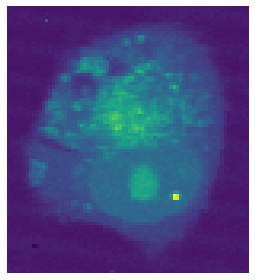

In [6]:
print(A.shape, Y.shape)
plot_image(Y)

In [7]:
def plot_spec(spec, wl = None):
    wave = wl if wl is not None else list(range(len(spec)))
    fig, ax = plt.subplots(1, 1, figsize = (8, 4))
    ax.plot(wave, spec)
    fig.tight_layout()
    plt.show()
    
def plot_spec_overlay(spec, wl = None, labels = None):
    wave = wl if wl is not None else list(range(spec.shape[1]))
    if not labels:
        labels = ['Spectrum {}'.format(i+1) for i in range(len(spec))]
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    for i in range(len(spec)):
        ax.plot(wave, spec[i,:], label = labels[i])
    ax.legend(loc = 'best')
    fig.tight_layout()
    plt.show()
    
def plot_spec_multi(spec, wl = None, labels = None, figsize = (15, 10)):
    n = len(spec)
    wave = wl if wl is not None else list(range(spec.shape[1]))
    if not labels:
        labels = ['Spectrum {}'.format(i+1) for i in range(n)]
    n_row = int(np.ceil(n / 2))
    fig, ax = plt.subplots(n_row, 2, figsize = figsize)
    for i in range(n):
        ax[i // 2, i % 2].plot(wave, spec[i,:])
        ax[i // 2, i % 2].set_title(labels[i])
    fig.tight_layout()
    plt.show()

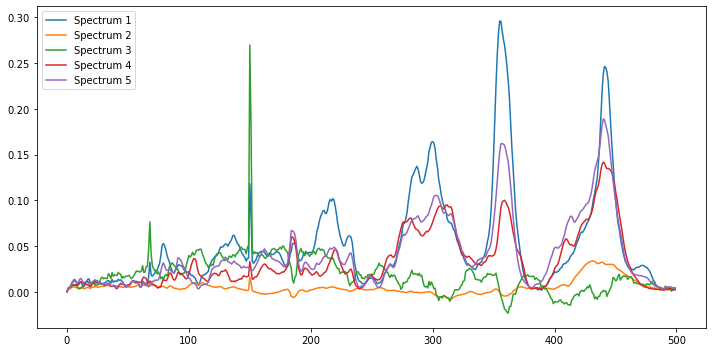

In [8]:
plot_spec_overlay(A)

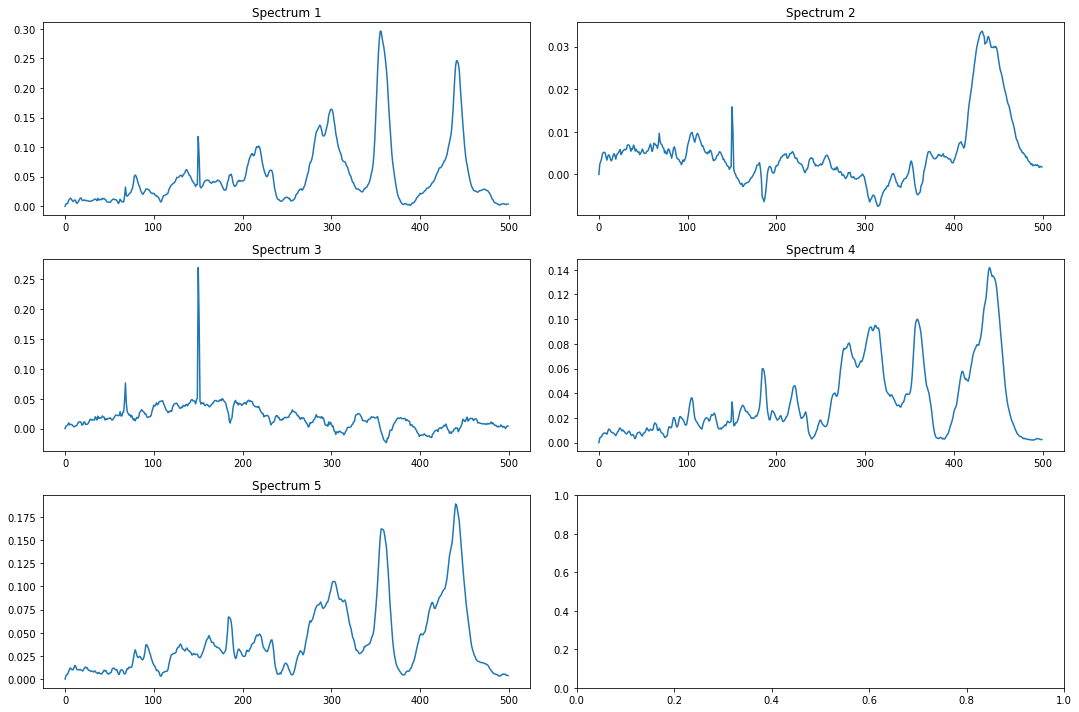

In [9]:
plot_spec_multi(A)

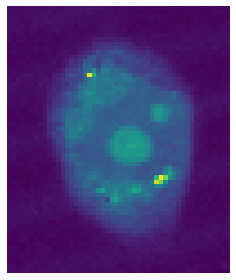

In [10]:
def normalise_image(image):
    # scales all values by max value
    image_max = np.tile(np.amax(image), image.shape)  # just image max repeated at every location
    normalised_image = np.divide(image, image_max)  
    return normalised_image

img2 = load_image(path, 'Cell-HR_Norm_500-03-077-130')
img2 = normalise_image(img2)
plot_image(img2)

SNR estimated = 17.85211621628446[dB]
Using projection onto R-1


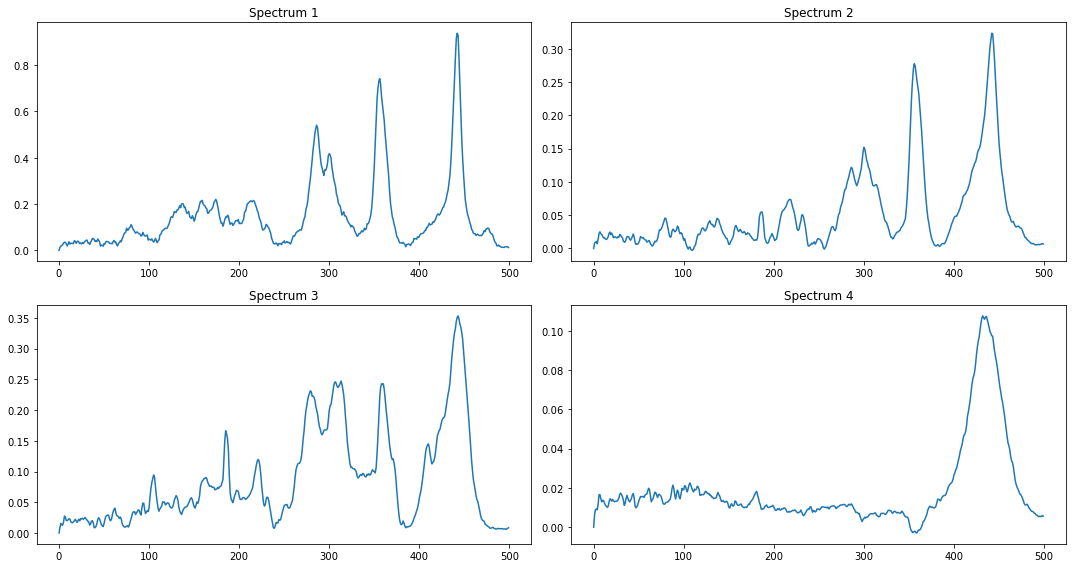

In [11]:
A2, pure_idx, Y2 = vca(img2, 4)
plot_spec_multi(A2, figsize = (15, 8))

In [12]:
def least_sq(img, comp):
    ''' Least-squares estimation of component abundances in spectral mixture '''
    nx, ny, nf = img.shape
    n_comp = len(comp)
    Y = img.reshape((nx * ny, nf)).T  # (channels, pixels)
    X = comp.T  # (channels, components)
    conc = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))  # (components, pixels)
    return conc.T.reshape((nx, ny, n_comp))

def non_neg_least_sq(img, comp):
    ''' Non-negative least-squares estimation of component abundances in spectral mixture '''
    nx, ny, nf = img.shape
    n_comp = len(comp)
    Y = img.reshape((nx * ny, nf))  # (pixels, channels)
    X = comp.T  # (channels, components)
    conc = np.zeros((nx * ny, n_comp))  # (pixels, components)
    for i in range(len(Y)):  # iterate through each pixel
        spec = Y[i,:]
        c, _ = nnls(X, spec)
        conc[i,:] = c
    return conc.reshape((nx, ny, n_comp))

In [13]:
img2_comp = non_neg_least_sq(img2, A2)

Comp. 1: 0.0 
Comp. 2: 0.22541922854639918 
Comp. 3: 0.35969761785651067 
Comp. 4: 0.3717802162882136


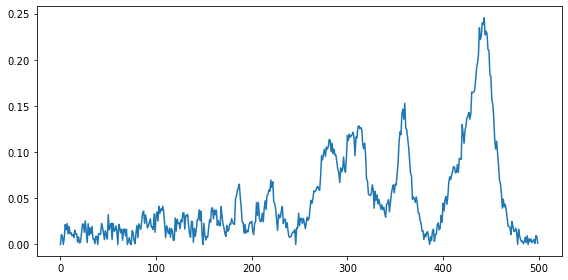

In [14]:
examp_pix = (35, 35)
print('Comp. 1:', img2_comp[examp_pix][0], '\nComp. 2:', img2_comp[examp_pix][1], 
      '\nComp. 3:', img2_comp[examp_pix][2], '\nComp. 4:', img2_comp[examp_pix][3])
plot_spec(img2[examp_pix])

In [43]:
def plot_VCA_image(img_components, comp_colors, labels = None, colorbar = True):
    n = len(comp_colors)
    
    # normalize components to sum to 1
    img_comp_scaled = img_components / img_components.sum(axis = 2)[..., np.newaxis]
    #img_comp_scaled = np.clip(img_components, 0, 1)
    
    # convert pixel values to RGB by taking weighted sum of component
    # abundances and their respective colors
    img_comp_rgb = np.dot(img_comp_scaled, np.array(comp_colors))
    img_comp_rgb = img_comp_rgb.round().astype(np.uint8)
    
    # plot RGB image
    fig, ax = plt.subplots(1, 1, figsize = (7, 5))
    ax.imshow(img_comp_rgb)
    ax.axis('off')
    
    # need to make custom discrete colorbar for component labels
    if colorbar:
        if not labels:
            labels = ['Component {}'.format(i+1) for i in range(n)]
        cmap = matplotlib.colors.ListedColormap(np.array(comp_colors)[::-1,:] / 255.)
        bounds = np.arange(0, n + 1) + 0.5
        norm = matplotlib.colors.BoundaryNorm(bounds, n)
        fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[::-1][norm(x)])
        #cb = matplotlib.colorbar.ColorbarBase(ax, cmap = cmap, norm = norm, format = fmt)
        sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
        fig.colorbar(sm, boundaries = bounds, format = fmt, ticks = np.arange(0, n + 1))
    
    fig.tight_layout()
    plt.show()

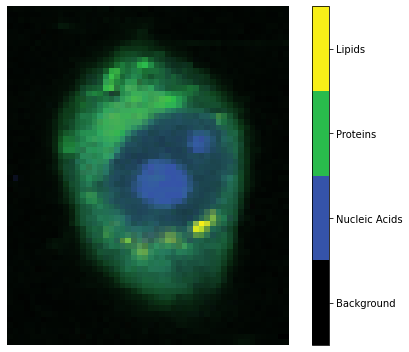

In [44]:
colors = [(248, 239, 24),
          (41, 187, 76),
          (53, 83, 169),
          (0, 0, 0)]

labels = ['Lipids', 'Proteins', 'Nucleic Acids', 'Background']
plot_VCA_image(img2_comp, colors, labels = labels, colorbar = True)

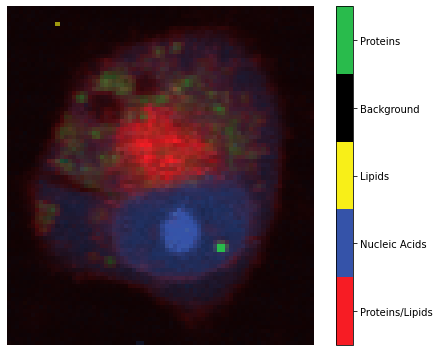

In [19]:
colors = [(41, 187, 76),
          (0, 0, 0),
          (248, 239, 24), 
          (53, 83, 169), 
          (247, 28, 36)]

img_comp = non_neg_least_sq(img, A)
labels = ['Proteins', 'Background', 'Lipids', 'Nucleic Acids', 'Proteins/Lipids']
plot_VCA_image(img_comp, colors, labels = labels, colorbar = True)